In [1]:
from odc.stac import load, configure_rio
import rasterio
import s3fs
import json
import pystac
import rioxarray
import leafmap

# Segment anything for Sentinel-2 data

The [Segment Anything Model](https://segment-anything.com/) is an AI
model to cut out features from an image.

This notebook requires extra libraries installed and needs a GPU instance
to work effectively.

This example using Sentinel-2 data works reasonably well if we use 20 m
pixels. 10 m pixels takes and exceedingly long time to run.

In [2]:
s3_uri = "s3://dea-public-data/baseline/ga_s2bm_ard_3/54/HYF/2023/01/25/20230125T014454/ga_s2bm_ard_3-2-1_54HYF_2023-01-25_final.stac-item.json"

# Region of interest to crop
minx, maxx, miny, maxy = 143.5,144.0,-35.8,-35.3
# Resolution
RESOLUTION = 20

# Open S3 object as a file using s3fs
s3 = s3fs.S3FileSystem(anon=True)
with s3.open(s3_uri, "rt") as f:
    stac_dict = json.load(f)
item = pystac.read_dict(stac_dict)

# Load the data, telling rasterio to not sign requests
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.ap-southeast-2.amazonaws.com",
)
data = load(
    [item],
    measurements=["green", "swir", "nir"],
    bbox=[minx, miny, maxx, maxy],
    resolution=RESOLUTION,
    stac_cfg={
        "ga_s2bm_ard_3": {
            "aliases": {
                "red": "nbart_red",
                "green": "nbart_green",
                "blue": "nbart_blue",
                "nir": "nbart_nir_1",
                "swir": "nbart_swir_2",
            }
        }
    },
    chunks={}
)

# No need for time
data = data.squeeze("time")


In [3]:
# Rescale red, green and blue bands from 0-10000 to 0-255

# Copy data into a new xarray
data_uint = data.copy(deep=True)

data_uint["swir"] = (data["swir"] / 5000 * 255).astype("uint8")
data_uint["nir"] = (data["nir"] / 5000 * 255).astype("uint8")
data_uint["green"] = (data["green"] / 3000 * 255).astype("uint8")

image = "s2_rgb.tif"
mask = "s2_mask.tif"
data_uint.rio.to_raster("s2_rgb.tif")

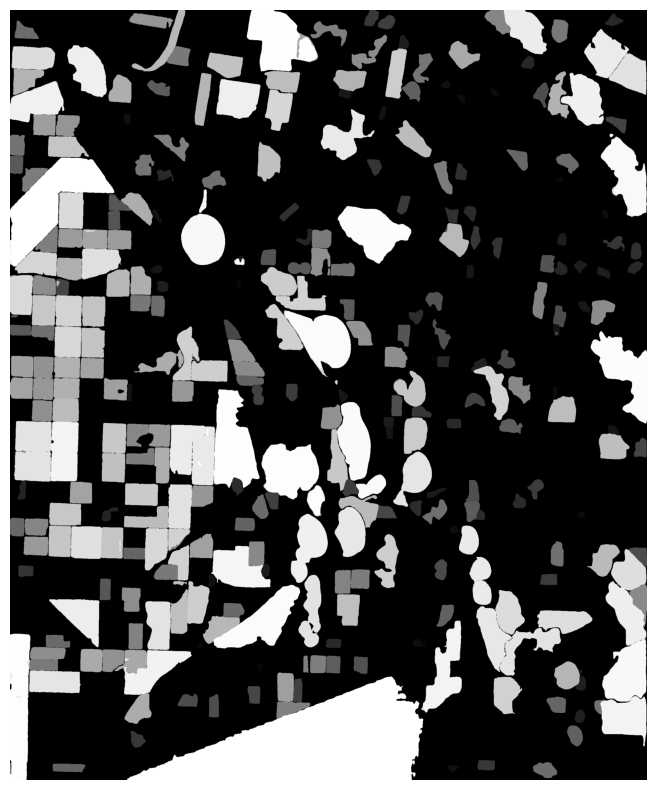

In [8]:
from samgeo import SamGeo

# Set up our model
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    sam_kwargs=sam_kwargs,
)

sam.generate(image, mask, foreground=False)
sam.show_masks()

In [9]:
sam.save_masks(mask)

In [10]:
vector = "segment.gpkg"
sam.tiff_to_gpkg(mask, vector, simplify_tolerance=None)